# Anime Collaborative Filtering

This notebook tries to find the best and worst anime of all time. Data is obtained from Kaggle Data base, which is taken from MyAnimeList. It stores a database of most of Anime ever released and a list of ratings submitted by users.

Kaggle Link: https://www.kaggle.com/CooperUnion/anime-recommendations-database

The model we are using is a standard Collaborative Filtering with a bias term. Using the bias term, we will be evaluating which anime is the best and worst of all time. From the latent factors, we will be evaluating, after reducing the dimentionality with PCA from 50 to 3, what each of the 3 latent factors mean.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
PATH = 'data/Anime Database/'

In [302]:
animes = pd.read_csv(f'{PATH}anime.csv')
ratings = pd.read_csv(f'{PATH}rating.csv')

In [303]:
animes.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [5]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


By creating a crosstab of top 15 most active user and top 15 most watched anime, we can see how the ratings table is spread and whether we should remove ratings that are -1 (watched, but no rating)

In [6]:
g = ratings.groupby('user_id')['rating'].count()
topUsers = g.sort_values(ascending=False)[:15]

g = ratings.groupby('anime_id')['rating'].count()
topAnimes = g.sort_values(ascending = False)[:15]

top_r = ratings.join(topUsers, rsuffix = '_r', how = 'inner', on = 'user_id')
top_r = top_r.join(topAnimes, rsuffix = '_r', how = 'inner', on = 'anime_id')

pd.crosstab(top_r.user_id, top_r.anime_id, top_r.rating, aggfunc = np.sum)

anime_id,20,121,199,226,1535,1575,2167,2904,4224,5114,6547,8074,10620,11757,16498
user_id,,,,,,,,,,,,,,,
7345,6.0,9.0,10.0,7.0,10.0,7.0,9.0,7.0,9.0,9.0,6.0,6.0,5.0,4.0,6.0
12431,NaN,NaN,8.0,3.0,6.0,NaN,6.0,NaN,7.0,7.0,7.0,6.0,6.0,7.0,6.0
27364,8.0,8.0,NaN,7.0,-1.0,-1.0,10.0,-1.0,10.0,9.0,7.0,10.0,9.0,10.0,-1.0
28521,7.0,8.0,10.0,NaN,9.0,-1.0,10.0,-1.0,9.0,10.0,10.0,7.0,8.0,6.0,3.0
40604,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,-1.0,10.0,-1.0,-1.0,-1.0,-1.0,9.0,9.0,8.0
42635,7.0,8.0,8.0,8.0,9.0,7.0,5.0,7.0,7.0,6.0,6.0,6.0,7.0,7.0,7.0
45659,8.0,8.0,9.0,8.0,8.0,9.0,10.0,8.0,10.0,10.0,7.0,7.0,9.0,8.0,9.0
48766,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
51693,NaN,8.0,8.0,7.0,9.0,9.0,7.0,9.0,9.0,10.0,8.0,NaN,7.0,8.0,8.0


As can be seen above, some of the cells are marked -1. This indicates that the user watched the show, but did not put a rating.

Initially, I decided that it if the user watched, but did not assign any rating, it's replaced by the mean. The justification is that if the user watched the show and did not put any rating, it can be considered just an average anime not worth the effort to rate. Later I discovered that this is not a good approach.

In [126]:
row = ratings[ratings.rating > 0]
mean_rating = np.mean(row.rating)

In [8]:
def replace_mean (x):
    if x < 0: return mean_rating
    else: return x

In [9]:
ratings['rating'] = ratings['rating'].apply(lambda x: replace_mean(x))

# Collaborative Filtering

Here we implemented a basic collab filtering model using the fast.ai library. The library itself is very comprehensive, with an embedding dot bias model as the default model in the learner and an implementation of ADAM as the optimizer. 

As such, this is a good benchmark to aim towards as we move on to implementing our own models later in the notebook. 

PS: Also helps that importing fast.ai library also imports the appropriate pytorch library :3

In [10]:
from fastai.learner import *
from fastai.column_data import *

In [11]:
val_idxs = get_cv_idxs(len(ratings))
wd = 2e-4
n_factors = 50
bs = 64

In [12]:
torch.cuda.is_available()
torch.backends.cudnn.enabled

True

In [13]:
cf = CollabFilterDataset.from_data_frame(PATH, ratings, 'user_id', 'anime_id', 'rating')
learn = cf.get_learner(n_factors, val_idxs, bs, opt_fn = optim.Adam)

After building the model, we find the appropriate LR

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot(100)

In [15]:
lr = 7e-4
epoch = 2

In [56]:
learn.fit(lr, epoch, wds = wd, cycle_len = 1, cycle_mult = 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                   
    0      1.648363   1.620104  
    1      1.559783   1.594456                                   
    2      1.487496   1.599271                                   


[1.5992708]

In [57]:
math.sqrt(1.5992708)

1.2646227896096132

In [ ]:
learn.save('anime_collab')

In [17]:
learn.load('anime_collab')

Let's look at the result. Looking at the joint plot, it seems that the model is working pretty well with the movies that are scored higher are predicted to have higher score according to our model

In [18]:
preds = learn.predict()

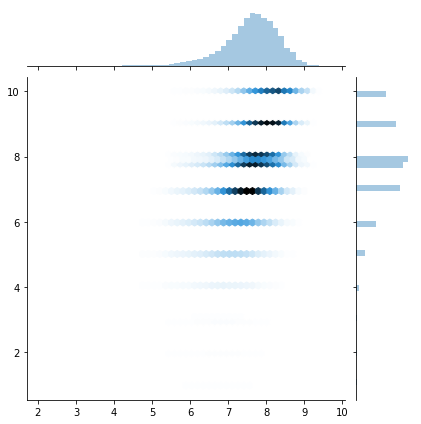

In [19]:
y = learn.data.val_y
sns.jointplot(preds, y, kind = 'hex', stat_func = None)

# Creating Our Own Model

This segment is more of a practice for my own benefit. It's to basically increase my understanding of what goes on behind the hood. 

The only thing that is not built froms cratch is our data model, ColumnarModelData, and the fit function, which runs controls the actual training. The EmbeddingDotBias model and the optimizer were initialized outside the fast.ai library

In [22]:
u_uniq = ratings.user_id.unique()
user2idx = {o:i for i, o in enumerate(u_uniq)}
ratings.user_id = ratings.user_id.apply(lambda x: user2idx[x])

a_uniq = ratings.anime_id.unique()
anim2idx = {o:i for i, o in enumerate(a_uniq)}
ratings.anime_id = ratings.anime_id.apply(lambda x: anim2idx[x])

n_users = int(ratings.user_id.nunique())
n_anime = int(ratings.anime_id.nunique())
#n_factors = 50 from above

For initialization, we can consider He initialization as described in: 

http://www.jefkine.com/deep/2016/08/08/initialization-of-deep-networks-case-of-rectifiers/

However, in this case, we used a simple uniform distribution as initialization

In [34]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_anime):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.a = nn.Embedding(n_anime, n_factors)
        self.u.weight.data.uniform_(0, 0.05)
        self.a.weight.data.uniform_(0, 0.05)
        
    def forward(self, cats, conts):
        users, movies = cats[:, 0], cats[:, 1]
        u, a = self.u(users), self.a(movies)
        return (u*a).sum(1)

In [23]:
x = ratings.drop(['rating'], axis = 1)
y = ratings['rating']

In [27]:
data = ColumnarModelData.from_data_frame(PATH, val_idxs, x, y, ['user_id', 'anime_id'], bs ,)

In [35]:
wd = 1e-5
model = EmbeddingDot(n_users, n_anime).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay = wd, momentum = 0.9)

In [36]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      2.013887   2.010096  
    1      1.872379   1.937718                                                                                         
    2      1.754884   1.906524                                                                                         


[1.9065237]

In [39]:
min_rating, max_rating = ratings.rating.min(), ratings.rating.max()

In [41]:
def get_emb(ni, nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01, 0.01)
    return e

In [42]:
class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_anime):
        super().__init__()
        (self.u, self.a, self.ub, self.ab) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_anime, n_factors), (n_users, 1), (n_anime, 1)
        ]]
        
    def forward(self, cats, conts):
        users, anime = cats[:, 0], cats[:, 1]
        ua = (self.u(users) * self.a(anime)).sum(1)
        res = ua + self.ub(users).squeeze() + self.ab(anime).squeeze()
        res = F.sigmoid(res) * (max_rating - min_rating) + min_rating
        return res

In [52]:
wd = 2e-4
model = EmbeddingDotBias(n_users, n_anime).cuda()
opt = optim.SGD(model.parameters(), lr = 1e-1, momentum = 0.9, weight_decay = wd)

In [53]:
fit(model, data, epochs = 3, opt = opt, crit = F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      1.582079   1.593083  
    1      1.594015   1.598181                                                                                         
    2      1.523659   1.587616                                                                                         


[1.5876161]

As you can see, the result is very similar between the fast.ai library and our own EmbeddingDotBias model. Although not the same, it approximates the fast.ai library really well and is a good practice to understand the inner workings of the model

# Analysis of Anime Bias Term

To analyze the quality of an Anime based on the data we have, we are going to examine the bias term that has been trained previously. 

In [58]:
anime_names = animes.set_index('anime_id')['name'].to_dict()
g = ratings.groupby('anime_id')['rating'].count()
top_anime = g.sort_values(ascending = False).index.values[:3000]
topAnimeIdx = np.array([anim2idx[o] for o in top_anime])

In [67]:
m = learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(73515, 50)
  (i): Embedding(11200, 50)
  (ub): Embedding(73515, 1)
  (ib): Embedding(11200, 1)
)

In [68]:
anime_bias = to_np(m.ib(V(topAnimeIdx)))

In [106]:
#anime_names

In [112]:
def get_ratings(top_anime, anime_bias):
    res = []
    for i, b in zip(top_anime, anime_bias):
        try:
            #print((b[0], anime_names[i]))
            res.append((b[0], anime_names[i]))
        except: 
            #print('no value in dict')
            pass
    return res

In [113]:
anime_ratings = get_ratings(top_anime, anime_bias)

In [116]:
sorted(anime_ratings, key = lambda x: x[0])[:15]

[(-1.029914,
  'Ranma ½: Chou Musabetsu Kessen! Ranma Team vs. Densetsu no Houou'),
 (-0.28323072, 'R.O.D OVA'),
 (-0.012725143, 'Parade Parade'),
 (0.008026532, 'One Piece: Yume no Soccer Ou!'),
 (0.057985224, 'Soukou Kijo Iris'),
 (0.097601615, 'Aa! Megami-sama!: Tatakau Tsubasa'),
 (0.124928474, 'Tachiguishi Retsuden'),
 (0.13034399, 'Munto'),
 (0.13363227, 'Tokusou Kihei Dorvack'),
 (0.13951989, 'Project ARMS'),
 (0.17719121, 'Venus Versus Virus'),
 (0.18581095, 'Project A-Ko 2: Daitokuji Zaibatsu no Inbou'),
 (0.18869591, 'Uchuu no Kishi Tekkaman Blade OVA: Burning Clock'),
 (0.19492525, 'Tetsuwan Birdy'),
 (0.197627, 'Gall Force: New Era')]

In [120]:
sorted(anime_ratings, key = lambda x: x[0], reverse = True)[:15]

[(2.1103315, 'Vandread: The Second Stage'),
 (2.0628364, 'Kaleido Star: Legend of Phoenix - Layla Hamilton Monogatari'),
 (1.9251881, 'JoJo no Kimyou na Bouken: Adventure'),
 (1.923822, 'Uta Kata'),
 (1.8802457, 'Touhai Densetsu Akagi: Yami ni Maiorita Tensai'),
 (1.8204362, 'Piano'),
 (1.7828794, 'Harukanaru Toki no Naka de: Ajisai Yumegatari'),
 (1.7617911, 'Mahou Sensei Negima!'),
 (1.7308434, 'Be-Boy Kidnapp&#039;n Idol'),
 (1.7274147, 'Musekinin Kanchou Tylor'),
 (1.7250144, 'Strange Dawn'),
 (1.7218348, 'FLCL'),
 (1.7198435, 'Aa! Megami-sama!: Sorezore no Tsubasa'),
 (1.6900251, 'Mazinkaiser'),
 (1.6886381, 'xxxHOLiC')]

As evident. The result is a little bit weird... There is no way Vandread: The Second Stage is the best anime of all time. This triggers us to relook our model. I suspect that replacing negative rating with the mean from our non-negative data is not a good approach.

# Dealing with negative ratings

## Removing negative entries

A potentially better approach is to remove the entries. I hesitate to do so because it can impact the accuracy of the model since we are essentially reducing the size data of our input.

In [133]:
ratings_df = pd.read_csv(f'{PATH}rating.csv')


In [136]:
row_neg = ratings_df[ratings_df.rating < 0]
ratio_neg = len(row_neg)/len(ratings_df) * 100
ratio_neg, (len(row_neg))

(18.896156858107716, 1476496)

So about 20% of the input is negative. There is still a good amount of data left if we were to remove these entries, so let's try to do that and see what happens to the result

In [138]:
ratings_remove = ratings_df.drop(row_neg.index)

In [144]:
val_idxs_remove = get_cv_idxs(len(ratings_remove))

In [145]:
cf = CollabFilterDataset.from_data_frame(PATH, ratings_remove, 'user_id', 'anime_id', 'rating')
learn = cf.get_learner(n_factors, val_idxs_remove, bs, opt_fn = optim.Adam)

In [146]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

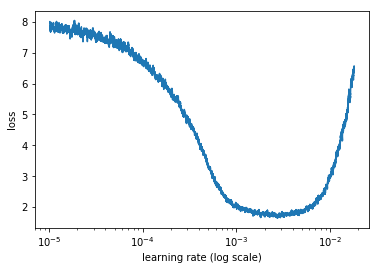

In [147]:
learn.sched.plot(100)

In [148]:
lr = 7e-4
epoch = 2

In [149]:
learn.fit(lr, epoch, wds = wd, cycle_len = 1, cycle_mult = 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      1.824749   1.855507  
    1      1.912379   1.810088                                                                                         
    2      1.770779   1.819356                                                                                         


[1.8193558]

The loss is higher than previously, probably due the lack of a big chunk of data that is equal to the mean. However, the actual rms value (1.35) looks quite good considering the score is between 0 to 10. 

In [288]:
math.sqrt(1.819356)

1.3488350529253013

In [286]:
learn.save('anime_collab_rem')

In [287]:
learn.load('anime_collab_rem')

# Analyzing Bias Term II

With our new dataset, it's time to relook the bias term once again. Also, to make the analysis easier to see, let's add a rank column

In [333]:
animes['rank'] = animes.apply(lambda x: x.index.values + 1)

In [337]:
anime_names = animes.set_index('anime_id')['name'].to_dict()
anime_rank = animes.set_index('anime_id')['rank'].to_dict()
g = ratings_remove.groupby('anime_id')['rating'].count()
top_anime = g.sort_values(ascending = False).index.values[:n_top]

anim2idx = {o: i for i, o in enumerate(ratings_remove.anime_id.unique())}

topAnimeIdx = np.array([anim2idx[i] for i in top_anime])

In [357]:
def get_ratings(top_anime, anime_bias):
    res = []
    for i, b in zip(top_anime, anime_bias):
        try:
            #print((b[0], anime_names[i]))
            res.append((b[0], anime_names[i], 'MAL Rank: ' + str(anime_rank[i])))
        except: 
            #print('no value in dict')
            pass
    return res

In [339]:
m_rem = learn.model; m_rem.cuda()

EmbeddingDotBias(
  (u): Embedding(69600, 50)
  (i): Embedding(9927, 50)
  (ub): Embedding(69600, 1)
  (ib): Embedding(9927, 1)
)

In [340]:
anime_bias_rem = to_np(m_rem.ib(V(topAnimeIdx)))

In [358]:
anime_rating_rem = get_ratings(top_anime, anime_bias_rem)

# 15 Best and Worse Anime According to MAL

There are some interesting observations to be seen here. 

It would seem that there is a little bit of score bloating happenening at the top of chart. Comparing the position of the entries on the official top anime chart and this analysis, it's clear that some ranks has been shuffled.

Some users tend to be overly-generous or overly-stingy in scoring entries. If enough of such user participates in the scoring process, the score reflected on the official rank can fluctuate. 

What the anime bias term represents is the tendency of all users giving a particular entry a higher or lower score, hence removing the biased user effect on the score. 

In [359]:
sorted(anime_rating_rem, key = lambda o: o[0], reverse = True)[:15]

[(2.335943, 'Fullmetal Alchemist: Brotherhood', 'MAL Rank: 2'),
 (2.2352605, 'Steins;Gate', 'MAL Rank: 4'),
 (2.110066, 'Clannad: After Story', 'MAL Rank: 11'),
 (2.0851614, 'Hunter x Hunter (2011)', 'MAL Rank: 7'),
 (2.0278265, 'Code Geass: Hangyaku no Lelouch R2', 'MAL Rank: 14'),
 (1.9773804, 'Gintama', 'MAL Rank: 13'),
 (1.916619, 'Gintama&#039;', 'MAL Rank: 5'),
 (1.9104565, 'Code Geass: Hangyaku no Lelouch', 'MAL Rank: 20'),
 (1.8997319, 'Tengen Toppa Gurren Lagann', 'MAL Rank: 30'),
 (1.8952312, 'Sen to Chihiro no Kamikakushi', 'MAL Rank: 16'),
 (1.8662899, 'One Punch Man', 'MAL Rank: 24'),
 (1.864013, 'Shigatsu wa Kimi no Uso', 'MAL Rank: 17'),
 (1.8475256, 'Death Note', 'MAL Rank: 41'),
 (1.8391311, 'Kimi no Na wa.', 'MAL Rank: 1'),
 (1.8386892, 'Cowboy Bebop', 'MAL Rank: 23')]

In [360]:
sorted(anime_rating_rem, key = lambda o: o[0])[:15]

[(-1.2376199, 'Hametsu no Mars', 'MAL Rank: 8057'),
 (-0.5716899, 'Pupa', 'MAL Rank: 8025'),
 (-0.2877884, 'Issho ni Sleeping: Sleeping with Hinako', 'MAL Rank: 7943'),
 (-0.22022736, 'Eiken: Eikenbu yori Ai wo Komete', 'MAL Rank: 7917'),
 (-0.17360754, 'Ame-iro Cocoa', 'MAL Rank: 7870'),
 (-0.15816203, 'Issho ni Training: Training with Hinako', 'MAL Rank: 7823'),
 (-0.15191877, 'Makura no Danshi', 'MAL Rank: 7819'),
 (-0.12552968, 'Osakana wa Ami no Naka', 'MAL Rank: 7711'),
 (-0.09237116, 'Boku no Pico', 'MAL Rank: 12218'),
 (-0.08896112, 'Pico x CoCo x Chico', 'MAL Rank: 12214'),
 (-0.0803521, 'Zettai Shougeki: Platonic Heart', 'MAL Rank: 7865'),
 (-0.074738584, 'Kämpfer Picture Drama', 'MAL Rank: 7353'),
 (-0.053772744, 'Legend of Duo', 'MAL Rank: 7701'),
 (-0.036306795, 'Diabolik Lovers Recap', 'MAL Rank: 7398'),
 (-0.035850298, 'Bikini Warriors', 'MAL Rank: 7527')]

# Closer Look at the Latent Factors

In this segment we take a closer look at the latent factors. Latent factors are like anime put into numbers. The 50 latent factors for each entry in our embedding matrix that we have describes the entry in its entirety. Each of the factor describes an aspect of the entry. 

Ideally, we should look into all 50 factors and try to study each of them if we want to understnad them fully. However, I don't have that kind of time. So, we'll use a dimentionality reduction technique called PCA to squish down the 50 factors to just 3. Honestly, we can look at more, but again, time. 

In [212]:
anime_emb = to_np(m_rem.i(V(topAnimeIdx)))
anime_emb.shape

(3000, 50)

In [227]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
anime_pca = pca.fit(anime_emb.T).components_

In [247]:
def get_fac(fac):
    res = []
    for f, i in zip(fac, top_anime):
        try:
            res.append((f, anime_names[i]))
        except: 
            pass
    return res

### First Latent Factor

First latent factor seems to indicate how much of an action vs dialog-driven/slice of life. We can see more action-oriented titles like SAO, Highschool of the Dead, Elfen Lied, etc at the top of the group. At the other end, we have more dialog-driven titles like Kino no Tabi, Showa Genroku Rakugo Shinjuu, and Mushishi that have slower pace, more plot driven, and generally more mature themes. 

In [248]:
fac0 = anime_pca[0]
anime_comp = get_fac(fac0)

In [250]:
sorted(anime_comp, key = lambda x: x[0], reverse = True)[:10]

[(0.20742454, 'Sword Art Online'),
 (0.16075054, 'Highschool of the Dead'),
 (0.12377403, 'Rosario to Vampire'),
 (0.12147653, 'Elfen Lied'),
 (0.11832247, 'High School DxD'),
 (0.11537564, 'Guilty Crown'),
 (0.11502026, 'Mirai Nikki (TV)'),
 (0.11038328, 'Zero no Tsukaima'),
 (0.1051308, 'Zero no Tsukaima: Princesses no Rondo'),
 (0.10414142, 'Sword Art Online II')]

In [251]:
sorted(anime_comp, key = lambda x: x[0], )[:10]

[(-0.010582777, 'Ginga Eiyuu Densetsu'),
 (-0.009296439, 'Yojouhan Shinwa Taikei'),
 (-0.0077025536, 'Shouwa Genroku Rakugo Shinjuu'),
 (-0.007567245, 'Kino no Tabi: The Beautiful World'),
 (-0.0075264666, 'Uchouten Kazoku'),
 (-0.0072735753, 'Ghost in the Shell'),
 (-0.006105613, 'Mushishi'),
 (-0.0060406975, 'Jinrui wa Suitai Shimashita'),
 (-0.005647008, 'Aria The Origination'),
 (-0.005600044, 'Aria The Origination: Sono Choppiri Himitsu no Basho ni...')]

### Second Latent Factor

I genuinely have no idea what this latent factor means.

In [253]:
fac1 = anime_pca[1]
anime_comp2 = get_fac(fac1)

In [254]:
sorted(anime_comp2, key = lambda x: x[0], reverse = True)[:10]

[(0.19456829, 'Sword Art Online'),
 (0.15723237, 'High School DxD'),
 (0.13860632, 'IS: Infinite Stratos'),
 (0.09829577, 'Guilty Crown'),
 (0.0861268, 'Tasogare Otome x Amnesia'),
 (0.084085666, 'To LOVE-Ru'),
 (0.08176879, 'No Game No Life'),
 (0.08113842, 'K'),
 (0.07924867, 'Rosario to Vampire Capu2'),
 (0.07790056, 'School Days')]

In [255]:
sorted(anime_comp2, key = lambda x: x[0])[:10]

[(-0.11985081, 'Soul Eater'),
 (-0.09659936, 'Mondaiji-tachi ga Isekai kara Kuru Sou Desu yo?'),
 (-0.095345676, 'Ore no Imouto ga Konnani Kawaii Wake ga Nai'),
 (-0.08861695, 'Chuunibyou demo Koi ga Shitai!'),
 (-0.087408625, 'IS: Infinite Stratos 2'),
 (-0.08448674, 'MM!'),
 (-0.08137746, 'Overlord'),
 (-0.08005196, 'Naruto'),
 (-0.07635123, 'Fate/stay night'),
 (-0.07525923, 'Mangaka-san to Assistant-san to The Animation')]

### Third Latent Factor

I also have no idea what this factor means.... If any of you knows what this means, please tell me.

In [264]:
fac2 = anime_pca[2]
anime_comp3 = get_fac(fac2)

In [259]:
sorted(anime_comp3, key = lambda x: x[0], reverse = True)[:10]

[(0.12027476, 'Another'),
 (0.11965621, 'Ore no Imouto ga Konnani Kawaii Wake ga Nai'),
 (0.106103815, 'Ore no Imouto ga Konnani Kawaii Wake ga Nai. Specials'),
 (0.10596142, 'Baka to Test to Shoukanjuu'),
 (0.09354161, 'No Game No Life'),
 (0.09159202, 'Omamori Himari'),
 (0.09143215, 'Love Live! School Idol Project'),
 (0.08545451, 'Zero no Tsukaima: Futatsuki no Kishi'),
 (0.08460391, 'Boku wa Tomodachi ga Sukunai Next'),
 (0.08344803, 'To LOVE-Ru')]

In [258]:
sorted(anime_comp3, key = lambda x: x[0])[:10]

[(-0.115013175, 'Rosario to Vampire Capu2'),
 (-0.10454094, 'Kyoukai no Kanata'),
 (-0.100915134, 'School Days'),
 (-0.09701901, 'Deadman Wonderland'),
 (-0.09490358, 'K-On!'),
 (-0.09343409, 'Accel World'),
 (-0.0871439, 'Black Bullet'),
 (-0.086815275, 'Tokyo Ghoul √A'),
 (-0.08158787, 'Ore no Imouto ga Konnani Kawaii Wake ga Nai.'),
 (-0.08104054, 'IS: Infinite Stratos')]

### 2D Visual Representation of the Latent Factors

Here we try to plot a 2D representation of the Latent Factors. It is plotted from 50 randomly picked entries out of the top 1000 watched anime. Each point represents the 50 latent factors that we trained earlier, squished into a 2D vector. Supposedly, anime that are closer together are similar in nature. You can say the distance between two points is directly proportional to how different they are from one another. 

If you think this is vague and very qualitative, it's because it is. This is the coolest bit about Neural Network, or Machine Learning in general. We are putting numbers to qualities; quantifying qualities of an entity. Amazing, right?

Honestly, this is more of an exercise than actual analysis since I don't actually have enough contextual knowledge to understand the plot, but please tell me if you can actually deduce something.



In [274]:
pca2D = PCA(n_components = 2)
anime_pca2D = pca2D.fit(anime_emb.T).components_

In [276]:
fac02D = anime_pca2D[0]
fac12D = anime_pca2D[1]

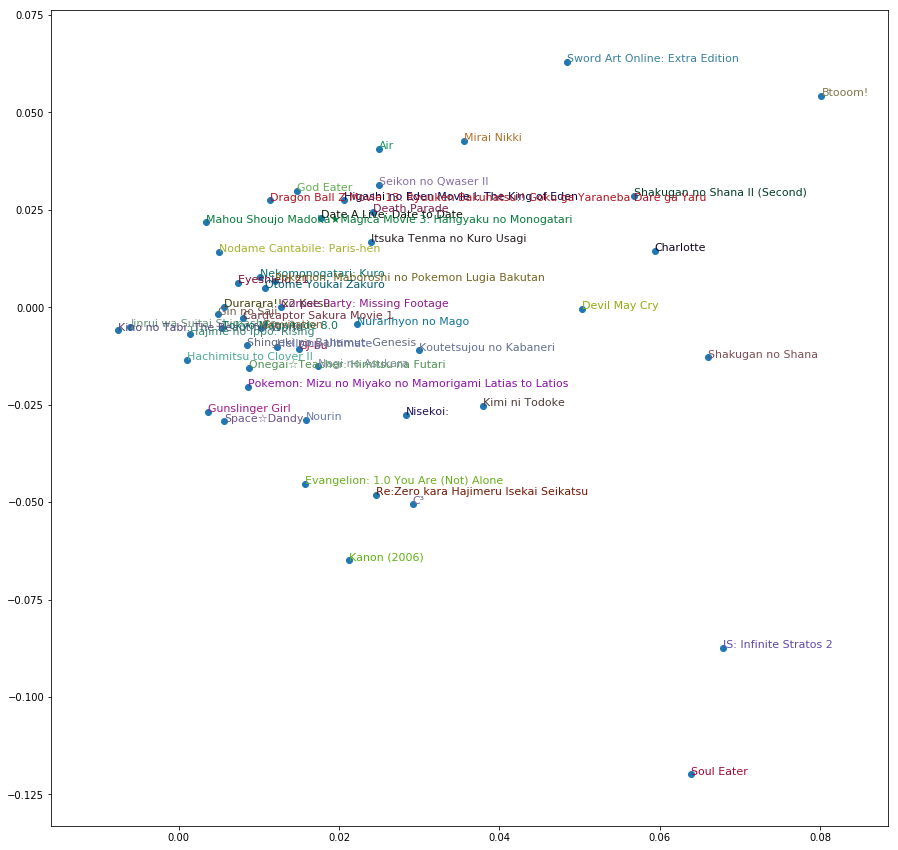

In [285]:
idx = np.random.choice(len(top_anime[:1000]), 50, replace = False)
X = fac02D[idx]
Y = fac12D[idx]

plt.figure(figsize = (15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_anime[idx], X, Y):
    plt.text(x, y, anime_names[i], color = np.random.rand(3)*0.7, fontsize = 11)
    
plt.show()